# Beyond Counting Individual Words: N-grams


So far in our journey through text data processing, we've dealt with counting individual words. While this approach, often referred to as a "bag of words" model, can provide a basic level of understanding and can be useful for certain tasks, it often falls short in capturing the true complexity and richness of language. This is mainly because it treats each word independently and ignores the context and order of words, which are fundamental to human language comprehension.

For example, consider the two phrases  
*"The movie is good, but the actor was bad."*  
and  
*"The movie is bad, but the actor was good."*  

If we simply count individual words, both phrases are identical because they contain the exact same words!
However, their meanings are diametrically opposed. The order of words and the context in which they are used are important.

## N-grams

**N-grams** are continuous sequences of n items in a given sample of text or speech. In the context of text analysis, an item can be a character, a syllable, or a word, although words are the most commonly used items. The integer *n* in "n-gram" refers to the number of items in the sequence, so a bigram (or 2-gram) is a sequence of two words, a trigram (3-gram) is a sequence of three words, and so on.

To illustrate, consider the two sentences above.
With 3-grams we could also get the pieces "movie is good", "movie is bad", "actor was bad", and "actor was good".
Bigrams (or 2-grams) would not catch those differences. But they can also be very helpful in cases such as "don't like" vs "do like".

Now we will see how we can make use of such n-grams.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.feature_extraction.text import TfidfVectorizer


# Set the ggplot style
plt.style.use("ggplot")

## N-grams in TF-IDF Vectors

When creating TF-IDF vectors, we can incorporate the concept of n-grams. The scikit-learn `TfidfVectorizer` provides the `ngram_range` parameter that allows us to specify the range of n-grams to include in the feature vectors. Setting this parameter to `(1, 3)` for instance, meant that 1-grams, 2-grams, and 3-grams will be included. So better be careful to not add too high numbers for ngram_range. Why? Well, let's see. But we will start by importing a dataset with plenty of text documents in it.

### Dataset - Madrid Restaurant Reviews
We will now use a large, text-based dataset containing more than 176.000 restaurant reviews from Madrid ([see dataset on zenodo](https://zenodo.org/records/6583422)). The dataset (about 142MB) can be downloaded via the following code block.

In the following, we will work with "only" the first 40,000 entries of this dataset. You can just re-run this code and use the full dataset. Question to you: Does this improve the models?

In [2]:
"""
This code block downloads the data from zenodo and stores it in a local 'datasets' folder.
"""

import requests
import os


def download_from_zenodo(url, save_path):
    """
    Downloads a file from a given Zenodo link and saves it to the specified path.

    Parameters:
    - url: The Zenodo link to the file to be downloaded.
    - save_path: Path where the file should be saved.
    """

    # Check if the file already exists
    if os.path.exists(save_path):
        print(f"File {save_path} already exists. Skipping download.")
        return None

    response = requests.get(url, stream=True)
    response.raise_for_status()

    with open(save_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    print(f"File downloaded successfully and saved to {save_path}")


# Zenodo link to the dataset
zenodo_link = r"https://zenodo.org/records/6583422/files/Madrid_reviews.csv?download=1"

# Path to save the downloaded dataset (you can modify this as needed)
output_path = os.path.join("..", "datasets", "madrid_reviews.csv")

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Download the dataset
download_from_zenodo(zenodo_link, output_path)

File ..\datasets\madrid_reviews.csv already exists. Skipping download.


In [3]:
NUM_REVIEWS = 40_000  # remove this part to re-run the following code on the full dataset!

filename = "../datasets/madrid_reviews.csv"
data = pd.read_csv(filename)
data = data.drop(["Unnamed: 0"], axis=1)
data = data.iloc[-NUM_REVIEWS:, :]
data.head()

,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,city,url_restaurant,author_id
136848,151539,Calcuta,2,Negative,review_154383514,Friendly fakey,'Vegetable Korma' was really just a bland yell...,'Vegetable Korma' was really just a bland yell...,"March 12, 2013",Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_83472
136849,151540,La_Tahona_de_Alburquerque,5,Positive,review_560721206,Great value & home made.,A typical restaurant/bar very popular with loc...,A typical restaurant/bar very popular with loc...,"February 15, 2018",Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_35302
136850,151541,La_Tahona_de_Alburquerque,3,Negative,review_178870964,Great salmon! Big serving.,Though the place looks a bit old and some of t...,Though the place looks a bit old and some of t...,"September 27, 2013",Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_83473
136851,151542,La_Tagliatella_C_C_Principe_Pio_Madrid,2,Negative,review_309030259,Apauling management,My boyfriend and I came here for a birthday lu...,My boyfriend and I came here for a birthday lu...,"September 10, 2015",Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_10033
136852,151544,La_Barraca,2,Negative,review_316597709,"Poor Service, paella was not prepared properly...",It is almost impossible to get a bad meal in M...,It is almost impossible to get a bad meal in M...,"October 6, 2015",Madrid,https://www.tripadvisor.com/Restaurant_Review-...,UID_83474


In [4]:
data.shape

(40000, 12)

As we can see, we have a pretty extensive dataset with many different restaurant reviews, our documents (`review_full`), as well as ratings (`rating_review`). We will use both of them in the following part. Let's first check a few random examples of our reviews, just to get a first idea of how the data looks like.

In [5]:
data.review_full.iloc[0]

"'Vegetable Korma' was really just a bland yellow curry?frozen peas & carrots, turmeric, milk, maybe a bit of onion. Papadums OK. Others said other dishes were fine. But all lacked the odors of the many spices I've come to expect from India."

## TF-IDF with Bigrams: Growing Vectors and Managing High Dimensionality

As we did in the previous chapters, we can simply use the Scikit-Learn `TfidfVectorizer` to create tfidf-vectors of our documents. But now with `ngram_range` set to more than just 1-grams. For a start, we will use 1-grams and 2-grams:

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# considers both unigrams and bigrams
vectorizer = TfidfVectorizer(ngram_range=(1, 2))  
tfidf_vectors = vectorizer.fit_transform(data.review_full)
tfidf_vectors.shape

(40000, 532156)

Look at the size of those vectors!

Even for 1-grams, the tfidf-vectors we saw in the previous chapters were rather large. But with higher n-grams, this can really explode because there are so much more possible combinations of words. 

So, clearly, using higher n-grams comes at a cost. The more we increase the size of our n-grams, the higher the dimensionality of our feature vectors. In the case of bigrams, for every pair of words that occur together in our text corpus, we add a new dimension to our feature space. This can quickly lead to an explosion of features. For instance, a modest vocabulary of 1,000 words leads to a potential of up to 1,000,000 (1,000 x 1,000) bigrams.

This high dimensionality can lead to two issues:

1. **Sparsity:** Most documents in the corpus will not contain most of the possible bigrams, leading to a feature matrix where most values are zero, i.e., a sparse matrix.
2. **Computational resources:** The computational requirement for storing and processing these feature vectors can become significant, especially for large text corpora.

Several techniques can help manage this high-dimensionality problem:

- **Feature selection:** We can limit the number of bigrams we include in our feature vector. This could be done based on the frequency of the bigrams. For example, we could choose to include only those bigrams that occur more than a certain number of times in the corpus.
- **Dimensionality reduction:** Techniques such as Principal Component Analysis (PCA) or Truncated Singular Value Decomposition (TruncatedSVD) can be used to reduce the dimensionality of the feature space, while preserving as much of the variance in the data as possible.
- **Using Hashing Vectorizer:** Scikit-learn provides a `HashingVectorizer` that uses a hash function to map the features to indices in the feature vector. This approach has a constant memory footprint and does not require to keep a vocabulary dictionary in memory, which makes it suitable for large text corpora.

It's important to weigh the trade-offs between capturing more context using n-grams and managing the resulting high dimensionality.

Let us here use the simplest way to reduce the tfidf vector size: a more restrictive feature selection!

### Restrict the Tfidf Vector Sizes
A very effective parameter for reducing the number of considered n-grams is `min_df`, the minimum document frequency.  
We could increase this to 10, so only n-grams that occur in at least 10 of our documents will be considered for our vectors.

In [7]:
vectorizer = TfidfVectorizer(min_df=10, max_df=0.2,
                             ngram_range=(1, 2))  
tfidf_vectors = vectorizer.fit_transform(data.review_full)
tfidf_vectors.shape

(40000, 36817)

This looks much better! Maybe we can even include 3-grams?

In [8]:
vectorizer = TfidfVectorizer(min_df=5, max_df=0.2,
                             ngram_range=(1, 3))  
tfidf_vectors = vectorizer.fit_transform(data.review_full)
tfidf_vectors.shape

(40000, 124025)

This looks OK, at least size-wise. The reason why this doesn't explode in terms of vector size is that the `min_df` parameter also counts for 2-grams, 3-grams etc. This here means that only the 3-grams which occur at least `min_df`-times will be kept.

Now we should check which ngrams the tfidf model finally included.

In [9]:
vectorizer.get_feature_names_out()[-100:]

array(['your table to', 'your tapa', 'your tapas', 'your tapas and',
       'your tapas crawl', 'your taste', 'your taste buds',
       'your tastebuds', 'your thing', 'your time', 'your time and',
       'your time here', 'your time in', 'your time or',
       'your time there', 'your time to', 'your to', 'your to do',
       'your tour', 'your trip', 'your trip to', 'your tummy',
       'your turn', 'your typical', 'your typical tapas', 'your usual',
       'your valuables', 'your visit', 'your visit to', 'your visiting',
       'your visiting madrid', 'your waiter', 'your wallet', 'your way',
       'your way around', 'your way in', 'your way through',
       'your way to', 'your wife', 'your wine', 'your wine and', 'youre',
       'yours', 'yourself', 'yourself and', 'yourself at',
       'yourself favor', 'yourself favor and', 'yourself favour',
       'yourself favour and', 'yourself for', 'yourself in',
       'yourself in madrid', 'yourself in the', 'yourself on',
       'yours

Well, that does not always immediately look like very good word combinations. And there are foreign language pieces still in our n-grams.
We do see a lot of 2-grams and 3-grams. Most combinations of 2 or 3 words, however, seem to be grammatically wrong.

Why is that?

The reason is that our selection criteria (using `min_df` and `max_df`) removed a lot of very common words so that **yes it does** becomes **yes does**.
But we can leave it to the machine learning algorithms now to make more sense of it.

First, however, it might be good the reduce the vectors a bit further.
Instead of manually adjusting the `min_df` many times, we can also use the parameter `max_features` to set an upper limit. This will remove all n-grams on the lower document frequency size until the set limit is reached.

In [10]:
vectorizer = TfidfVectorizer(min_df=5, max_df=0.2,
                             ngram_range=(1, 3),
                             max_features=10_000,
                            )  
tfidf_vectors = vectorizer.fit_transform(data.review_full)
tfidf_vectors.shape

(40000, 10000)

In [11]:
vectorizer.get_feature_names_out()[-100:]

array(['you can', 'you can also', 'you can buy', 'you can choose',
       'you can eat', 'you can enjoy', 'you can find', 'you can get',
       'you can go', 'you can have', 'you can order', 'you can see',
       'you can sit', 'you can try', 'you cannot', 'you choose',
       'you come', 'you could', 'you do', 'you do not', 'you don',
       'you don want', 'you eat', 'you enjoy', 'you enter', 'you expect',
       'you feel', 'you feel like', 'you find', 'you for', 'you get',
       'you get to', 'you go', 'you go to', 'you had', 'you have',
       'you have the', 'you have to', 'you in', 'you just', 'you know',
       'you like', 'you like to', 'you ll', 'you ll be', 'you ll find',
       'you love', 'you make', 'you may', 'you might', 'you must',
       'you must visit', 'you need', 'you need to', 'you order',
       'you pay', 'you pay for', 'you re', 'you re in', 'you re looking',
       'you re not', 'you really', 'you see', 'you should', 'you sit',
       'you that', 'you the', 

OK, this looks quite good. Let's try to work with those settings.

First, we do a data split to later train a machine learning model:

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data.review_full, data.rating_review, test_size=0.2, random_state=0)

print(f"Train dataset size: {X_train.shape}")
print(f"Test dataset size: {X_test.shape}")    

Train dataset size: (32000,)
Test dataset size: (8000,)


This time we will start right away with a classification model:

### Logistic Regression model
To later compare models, we will start without n-grams!

And, **important**: We have to set the tfidf-vectorizer on **only** the training data!

In [13]:
vectorizer = TfidfVectorizer(min_df=10, max_df=0.2,
                             max_features=10000,
                             #ngram_range=(1, 3)
                            )  
tfidf_vectors = vectorizer.fit_transform(X_train)
tfidf_vectors.shape

(32000, 5919)

In [14]:
vectorizer.get_feature_names_out()[-100:]

array(['widely', 'wider', 'wife', 'wifi', 'wild', 'will', 'willing',
       'win', 'wind', 'window', 'windows', 'wine', 'wines', 'wings',
       'winner', 'winning', 'winter', 'wiped', 'wise', 'wisely', 'wish',
       'wished', 'wishes', 'within', 'without', 'witnessed', 'wok',
       'woman', 'women', 'won', 'wonder', 'wondered', 'wonderful',
       'wonderfull', 'wonderfully', 'wondering', 'wont', 'wood', 'wooden',
       'word', 'words', 'wore', 'work', 'worked', 'workers', 'working',
       'works', 'world', 'worlds', 'worn', 'worried', 'worries', 'worry',
       'worse', 'worst', 'worth', 'worths', 'worthwhile', 'worthy',
       'would', 'wouldn', 'wouldnt', 'wow', 'wrap', 'wrapped', 'wraps',
       'write', 'writers', 'writing', 'written', 'wrong', 'wrote', 'xo',
       'xx', 'yamil', 'yeah', 'year', 'years', 'yelled', 'yelling',
       'yellow', 'yes', 'yesterday', 'yet', 'yo', 'yoghurt', 'yogurt',
       'york', 'young', 'younger', 'your', 'youre', 'yourself',
       'yourselve

By the way: Why did we now get less than max_features?

In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=300)  # don't worry it also works without setting max_iter
model.fit(tfidf_vectors, y_train)

LogisticRegression(max_iter=300)

We will then use the before initialized tfidf-vectorizer to process our test data.

In [16]:
tfidf_vectors_test = vectorizer.transform(X_test)
predictions = model.predict(tfidf_vectors_test)

In [17]:
np.round(predictions[:20], 1)

array([5, 3, 4, 1, 5, 5, 1, 5, 4, 5, 4, 5, 5, 4, 5, 4, 5, 1, 5, 5],
      dtype=int64)

In [18]:
y_test[:20].values

array([4, 3, 3, 1, 4, 4, 1, 4, 4, 5, 5, 4, 5, 5, 5, 3, 1, 1, 4, 5],
      dtype=int64)

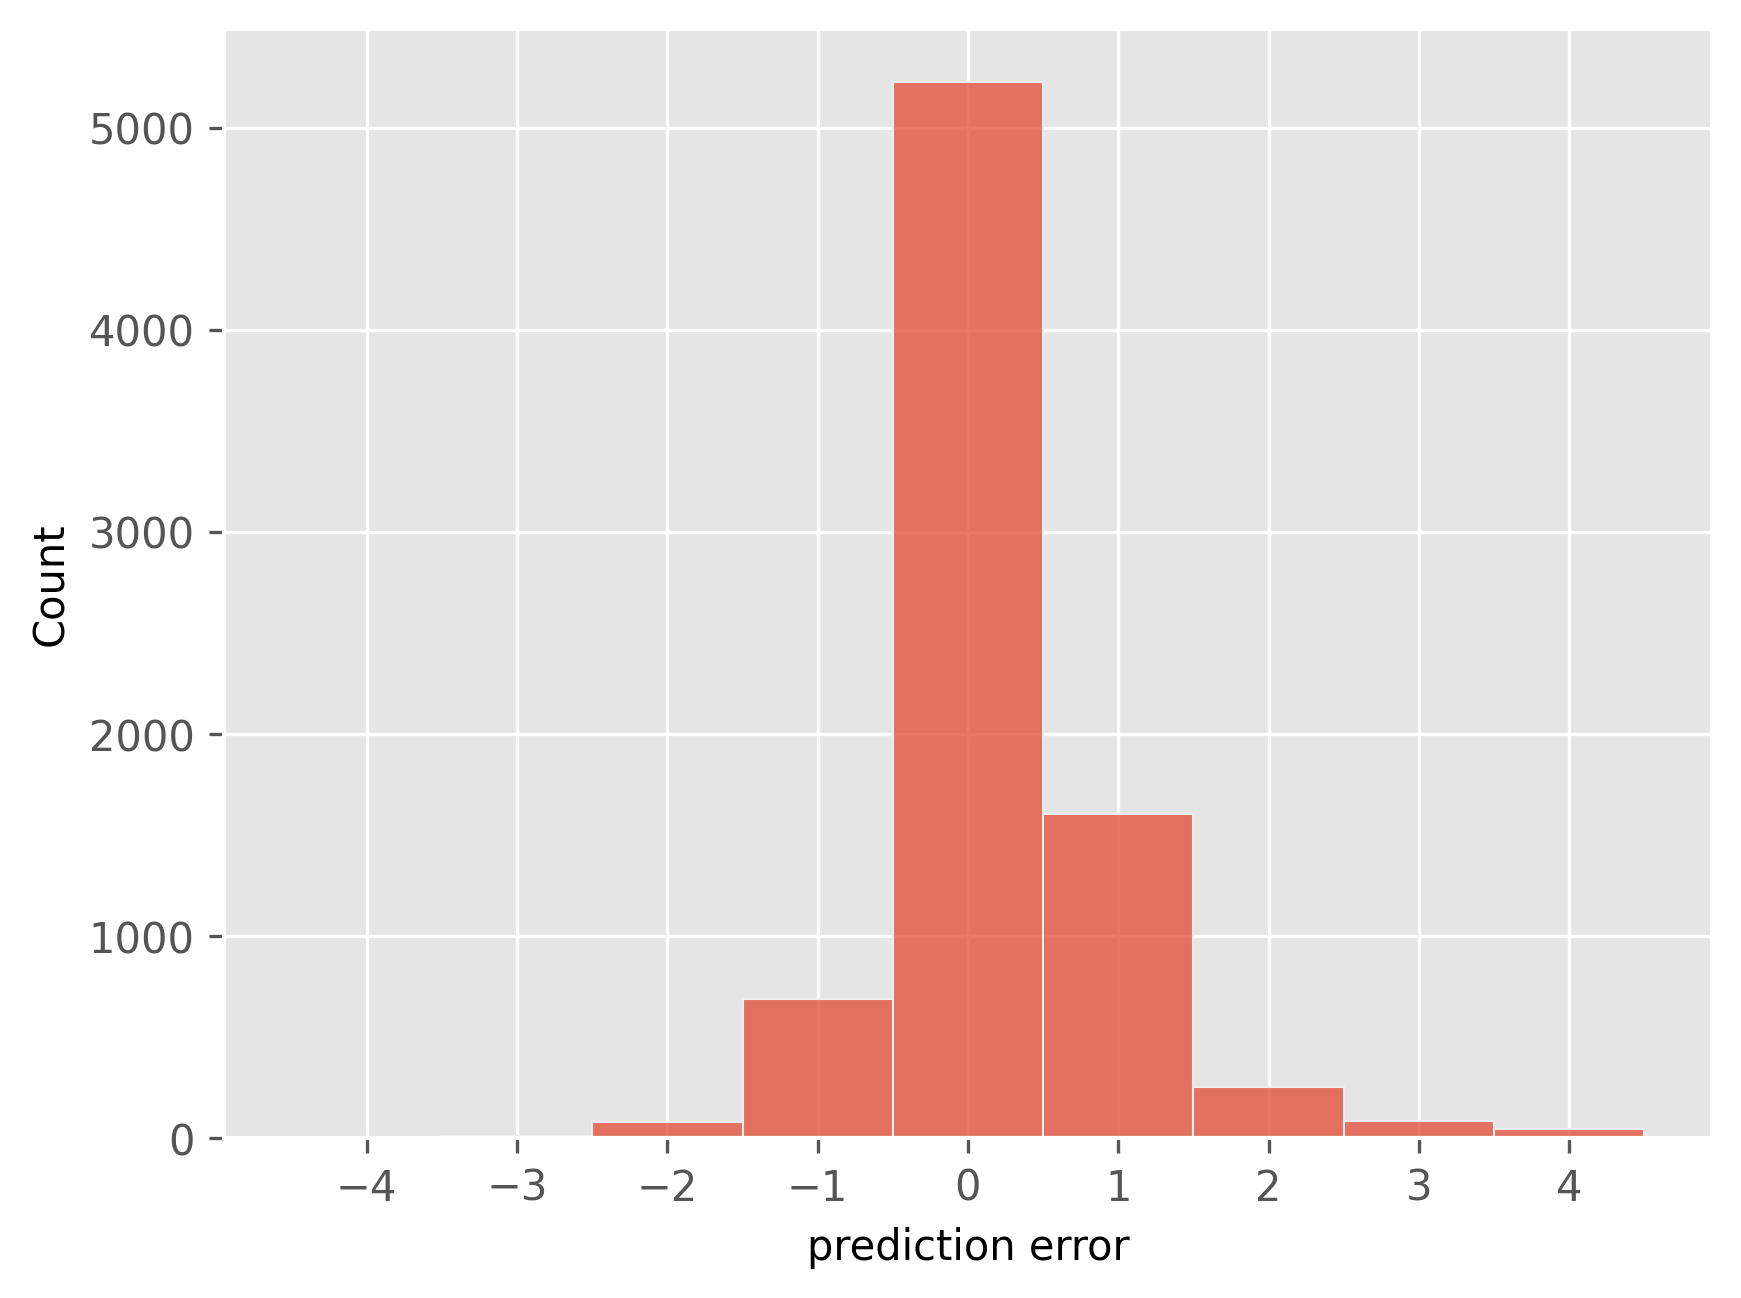

In [19]:
bins = np.arange(-4.5, 5.5, 1)

plt.figure(dpi=300)
sb.histplot(predictions - y_test, bins=bins)
plt.xlabel("prediction error")
plt.xticks(range(-4, 5))  # Set x-ticks to be all integers between -4 and 4
plt.show()

In [20]:
print(f"Mean absolute error (MAE): {np.abs(predictions - y_test).mean():.4f}")

0.432

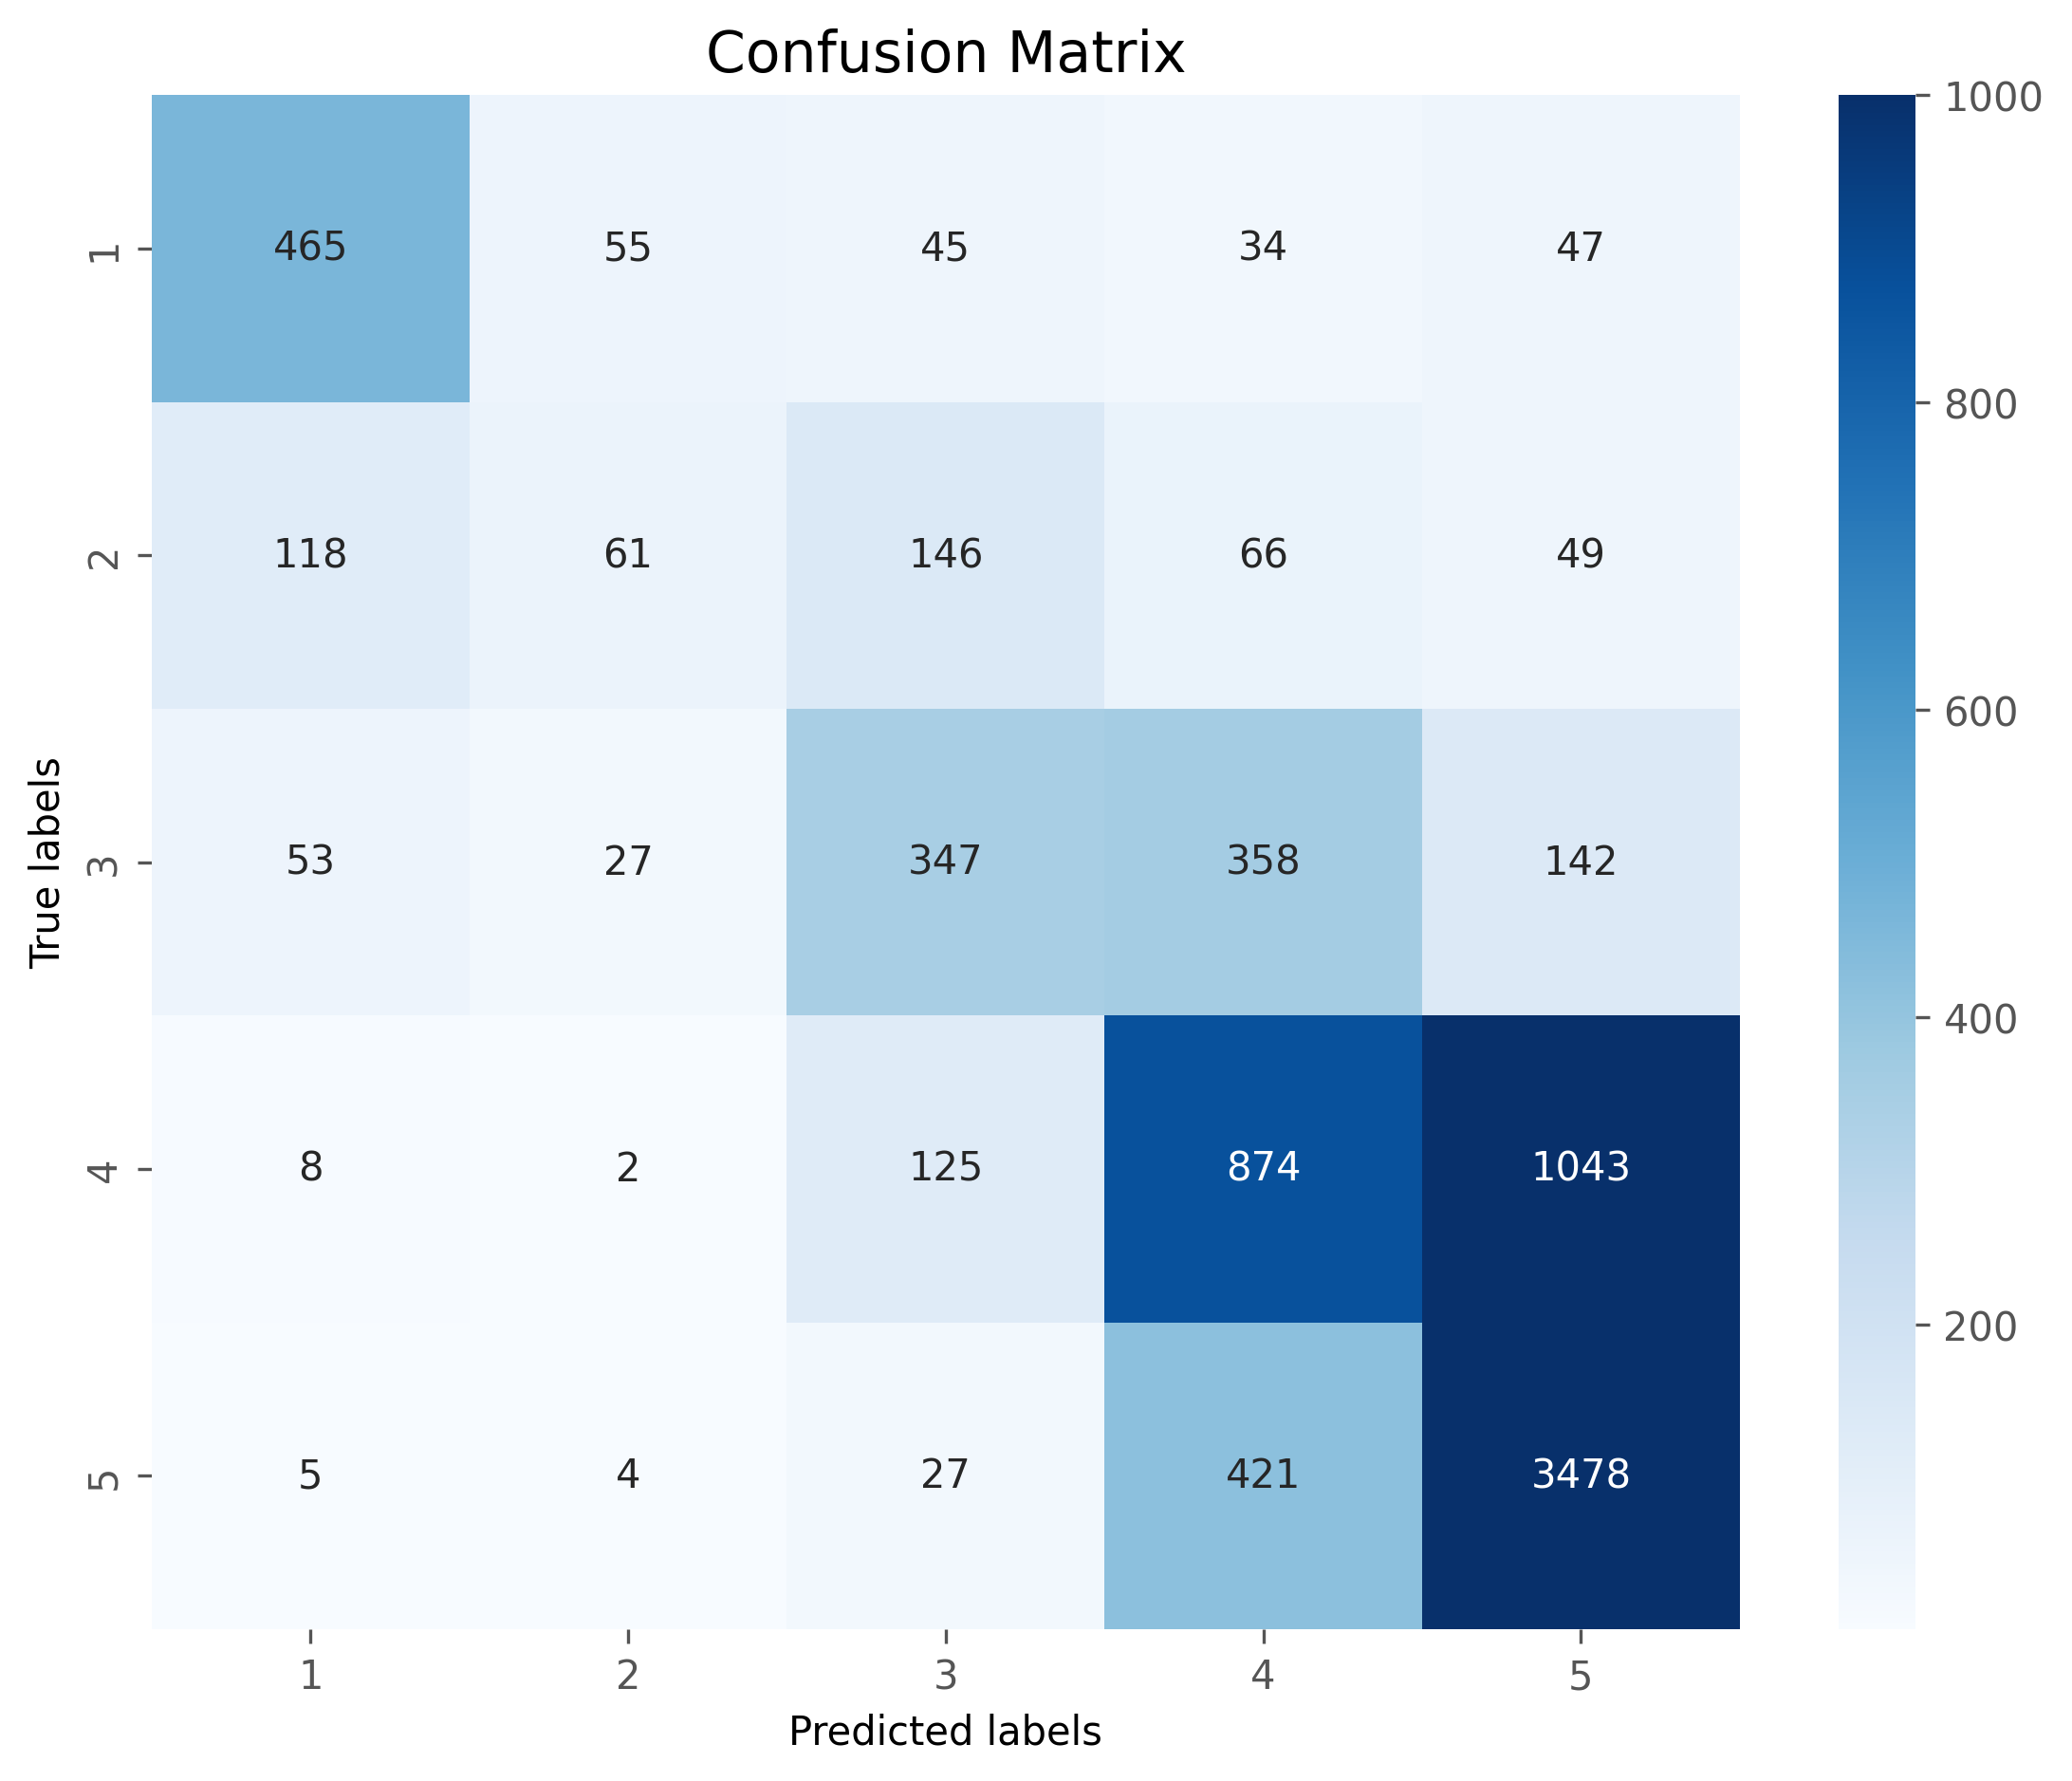

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, predictions, labels=model.classes_)

# Plotting the confusion matrix with a heatmap
plt.figure(figsize=(9,7), dpi=300)
sb.heatmap(cm, annot=True, fmt='d',
           cmap='Blues',
           xticklabels=model.classes_,
           yticklabels=model.classes_,
           vmax=1000,
          )
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### Look at the Vectors

How do our vectors look like?
Luckily, they are stored as sparse arrays so that only the (few) non-zero elements are actually being kept in memory. Often, our document tfidf-vectors will only contain a tiny fraction of all included n-grams:

In [22]:
tfidf_vectors[0, :].data

array([0.37297901, 0.2354731 , 0.22733288, 0.24375703, 0.18328515,
       0.21729833, 0.19654302, 0.19799178, 0.35615086, 0.26211929,
       0.32327298, 0.22927572, 0.37750596, 0.20140989])

In [23]:
tfidf_vectors[0, :].indices

array([2637, 3471,  305, 1045, 4137,  499, 1948, 1161,  203, 2658, 3070,
       2619, 1603, 5721])

And? What has our model actually learned?

In [24]:
example_vector = pd.DataFrame({
    "word": vectorizer.get_feature_names_out()[tfidf_vectors[0, :].indices],
    "tfidf": tfidf_vectors[0, :].data
})
example_vector

,word,tfidf
0,hundreds,0.372979
1,near,0.235473
2,another,0.227333
3,choose,0.243757
4,quality,0.183285
5,bad,0.217298
6,expensive,0.196543
7,come,0.197992
8,ages,0.356151
9,ice,0.262119


### Logistic Regression model + n-grams

Let us now re-run the same thing, but use n-grams.

In [25]:
vectorizer = TfidfVectorizer(min_df=10, max_df=0.2,
                             max_features=10000,
                             ngram_range=(1, 3)
                            )  
tfidf_vectors = vectorizer.fit_transform(X_train)
tfidf_vectors.shape

(32000, 10000)

In [26]:
vectorizer.get_feature_names_out()[-100:]

array(['you can also', 'you can buy', 'you can choose', 'you can eat',
       'you can enjoy', 'you can find', 'you can get', 'you can go',
       'you can have', 'you can order', 'you can see', 'you can sit',
       'you can try', 'you cannot', 'you choose', 'you come', 'you could',
       'you do', 'you do not', 'you don', 'you don have', 'you don want',
       'you eat', 'you enjoy', 'you enter', 'you expect', 'you feel',
       'you feel like', 'you find', 'you for', 'you get', 'you get to',
       'you go', 'you go to', 'you had', 'you have', 'you have the',
       'you have to', 'you in', 'you just', 'you know', 'you like',
       'you ll', 'you ll be', 'you ll have', 'you love', 'you make',
       'you may', 'you might', 'you must', 'you must visit', 'you need',
       'you need to', 'you order', 'you pay', 'you pay for', 'you re',
       'you re in', 'you re looking', 'you re not', 'you really',
       'you see', 'you should', 'you sit', 'you that', 'you the',
       'you to', 

In [27]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=300)  # don't worry it also works without setting max_iter
model.fit(tfidf_vectors, y_train)

LogisticRegression(max_iter=300)

In [28]:
tfidf_vectors_test = vectorizer.transform(X_test)
predictions = model.predict(tfidf_vectors_test)

In [29]:
np.round(predictions[:20], 1)

array([5, 4, 4, 1, 4, 5, 1, 4, 5, 5, 4, 5, 5, 4, 4, 4, 4, 1, 5, 5],
      dtype=int64)

In [30]:
y_test[:20].values

array([4, 3, 3, 1, 4, 4, 1, 4, 4, 5, 5, 4, 5, 5, 5, 3, 1, 1, 4, 5],
      dtype=int64)

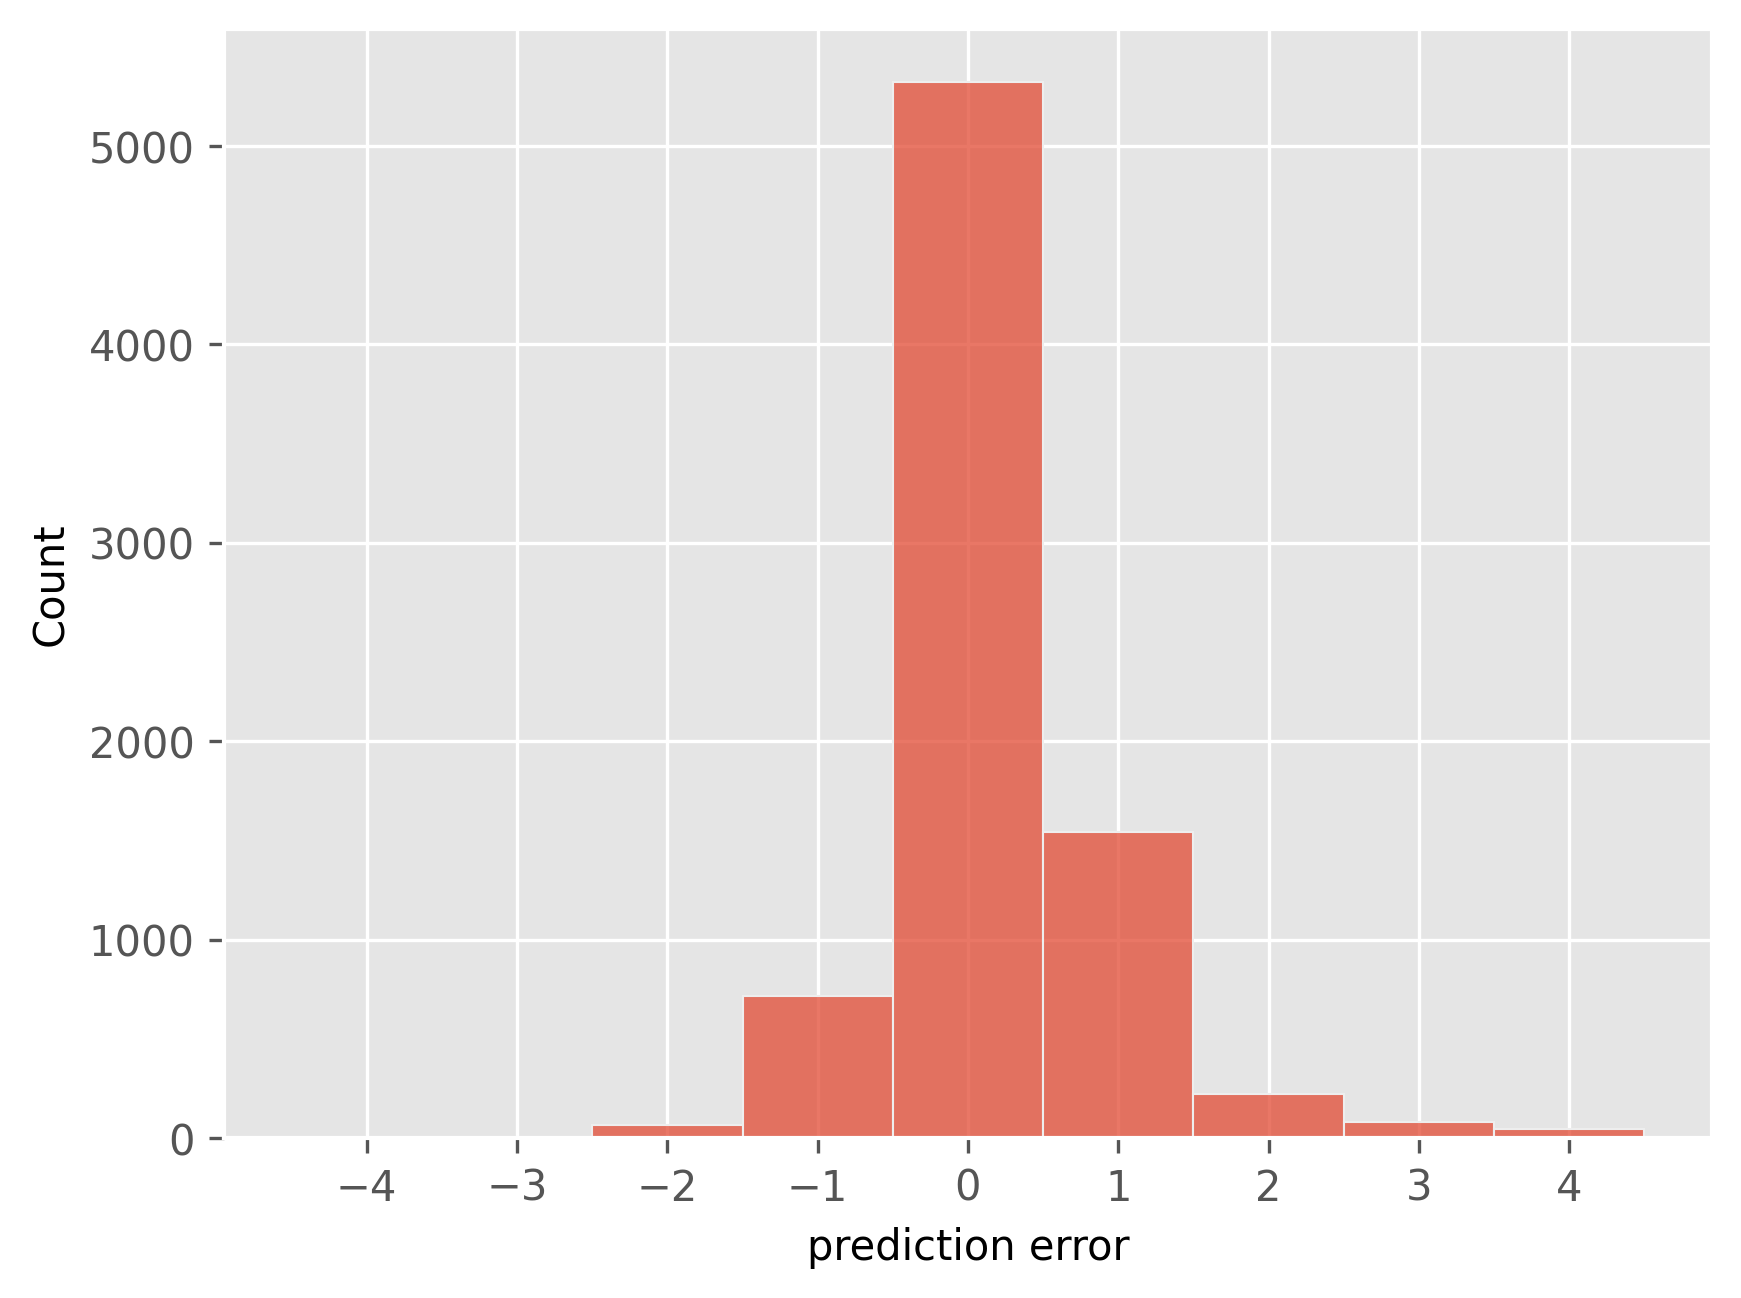

In [31]:
bins = np.arange(-4.5, 5.5, 1)

plt.figure(dpi=300)
sb.histplot(predictions - y_test, bins=bins)
plt.xlabel("prediction error")
plt.xticks(range(-4, 5))
plt.show()

In [32]:
print(f"Mean absolute error (MAE): {np.abs(predictions - y_test).mean():.4f}")

Mean absolute error (MAE): 0.4089


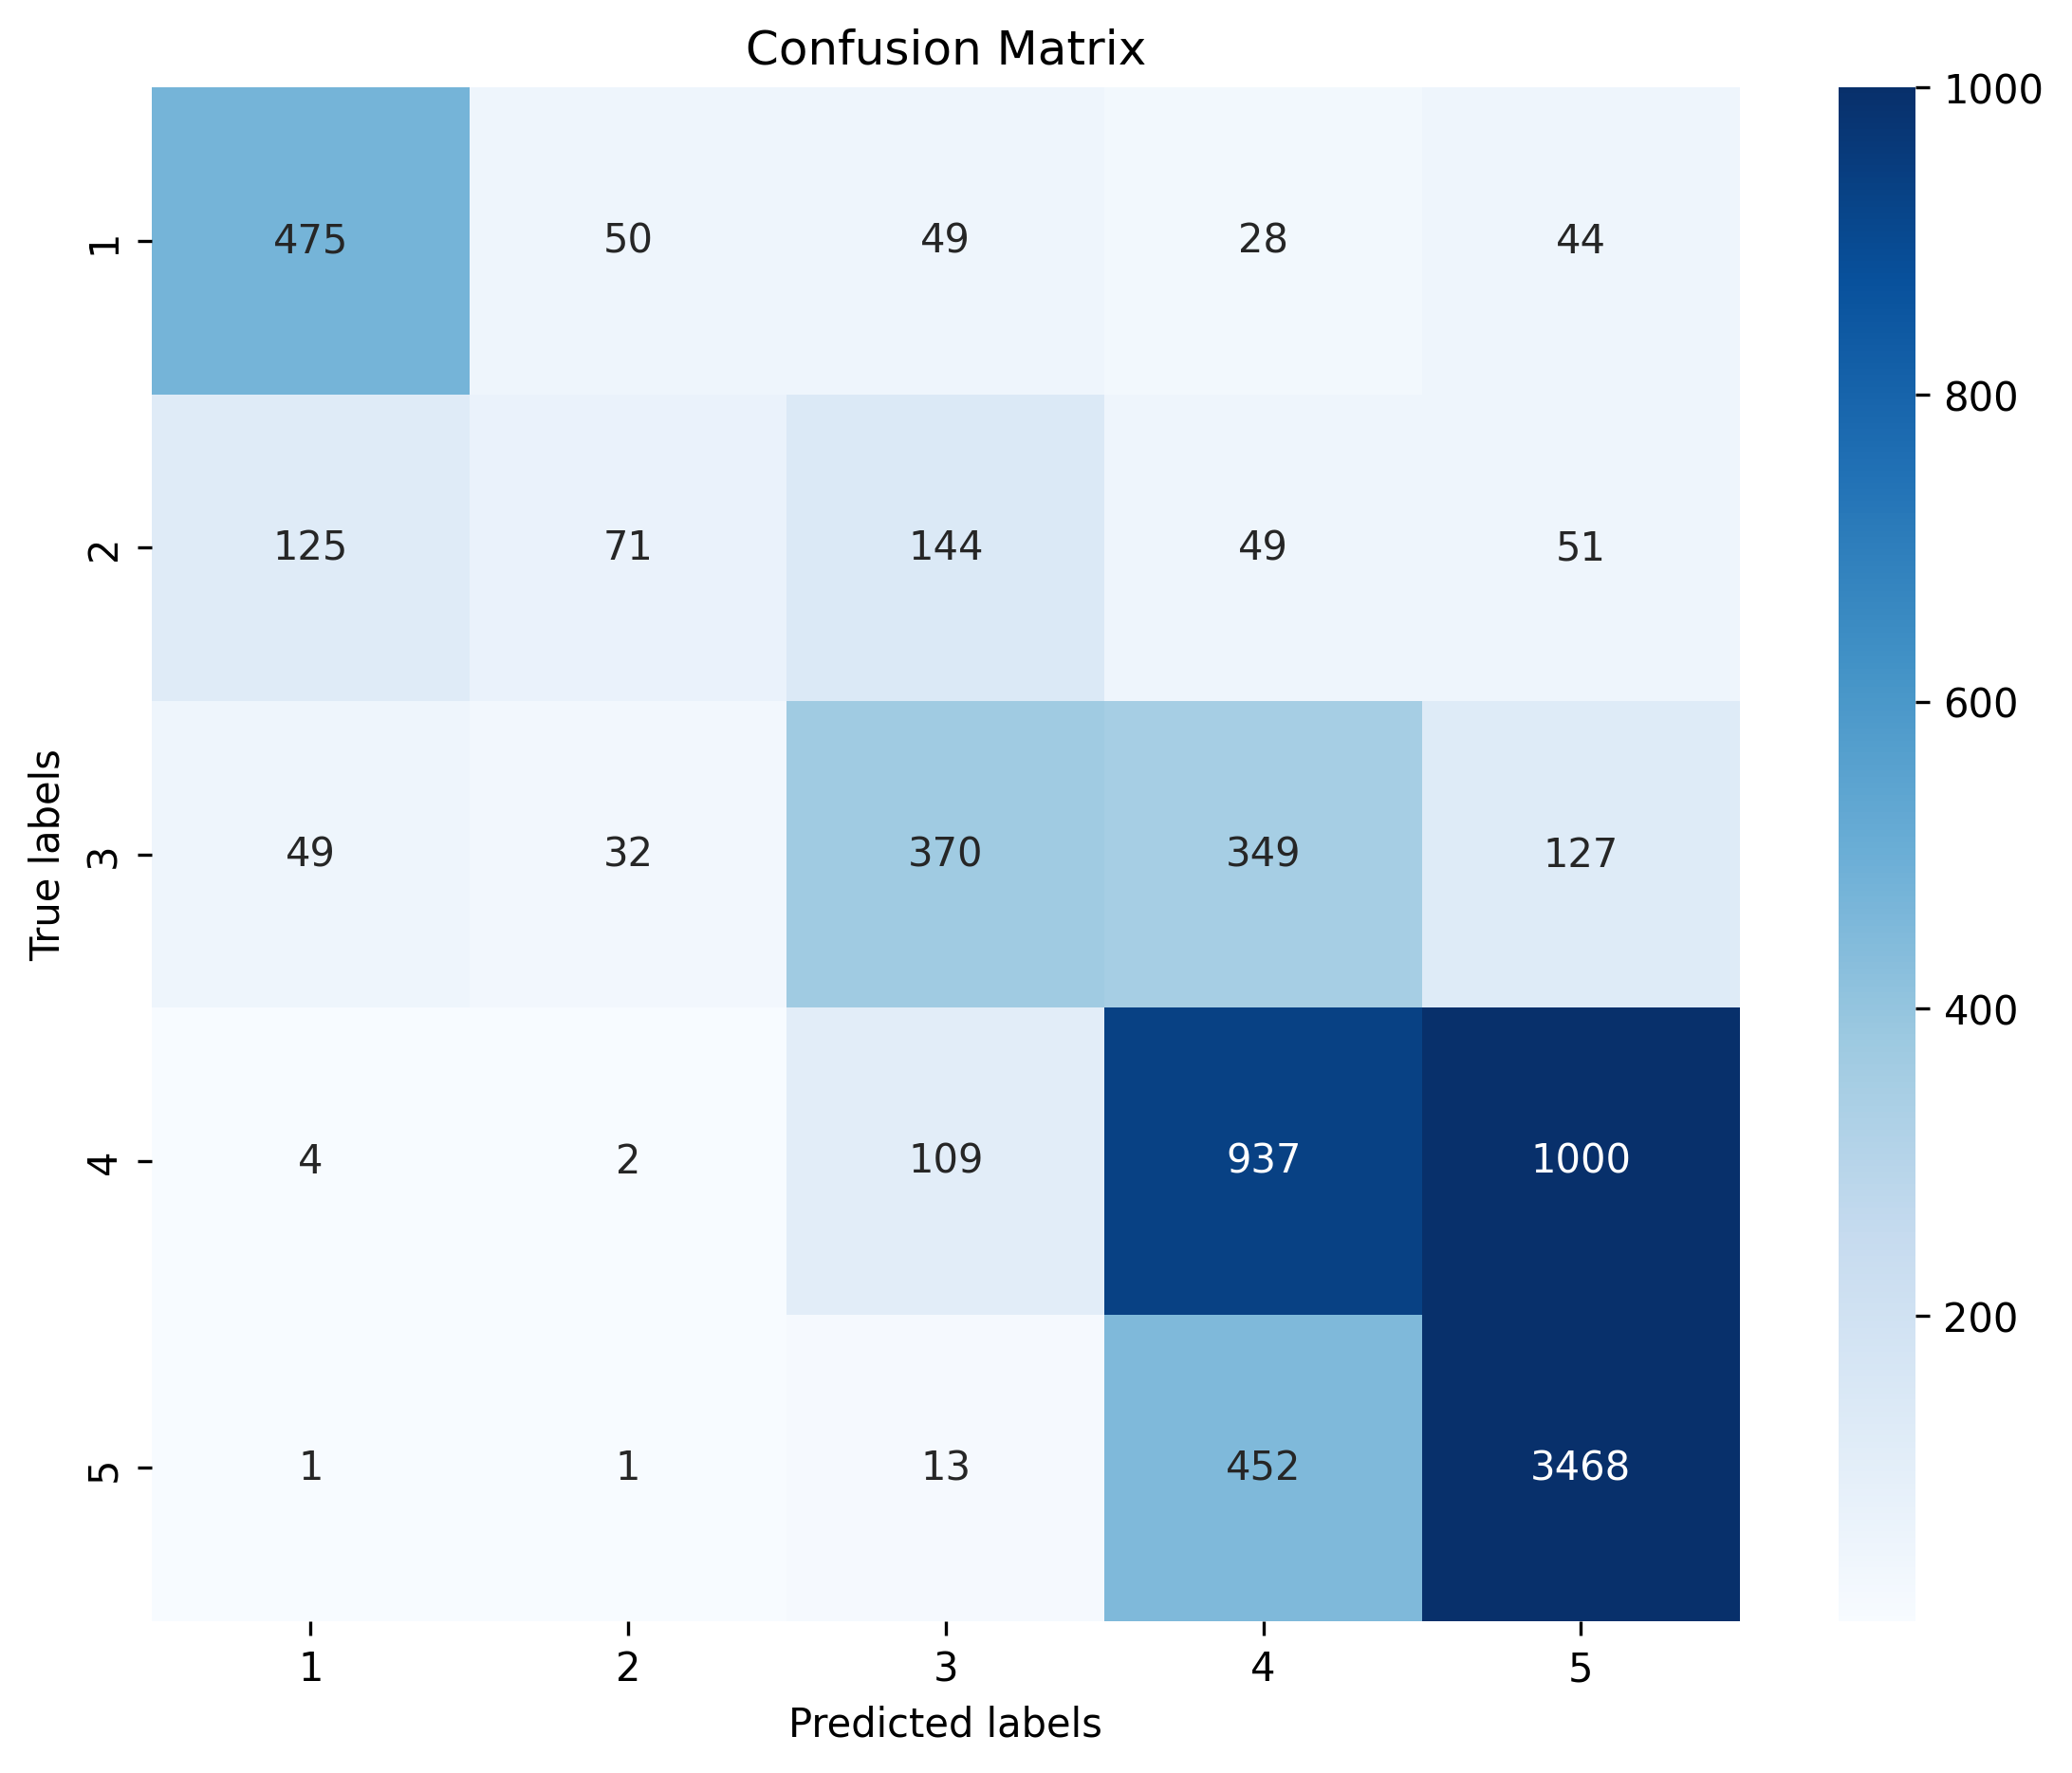

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, predictions, labels=model.classes_)

# Plotting the confusion matrix with a heatmap
plt.figure(figsize=(9,7), dpi=300)
sb.heatmap(cm, annot=True, fmt='d',
           cmap='Blues',
           xticklabels=model.classes_,
           yticklabels=model.classes_,
           vmax=1000
          )
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Did the 2-grams and 3-grams help?
Well, the prediction accuracy only got slightly better. So, it seems to have *some* effect, but nothing spectacular. However, this is not a general finding and might look very differently for other datasets or problems.

We can now also look at the ngrams that have the largest impact on the model predictions:

In [34]:
ngrams = pd.DataFrame({"ngram": vectorizer.get_feature_names_out(),
                       "weight": model.coef_[0]
                      })
ngrams.sort_values("weight")

,ngram,weight
2033,delicious,-3.204672
8734,very good,-2.810576
2488,excellent,-2.806501
7225,tasty,-2.432622
3002,friendly,-2.288946
...,...,...
6375,rude,4.336951
1037,avoid,4.355082
1082,bad,4.944697
9822,worst,5.015257


Here, too, we find only very few 2-grams in the top-20 and bottom-20 lists. Most of the times, the model still seems to judge the reviews based on individual words.

In [35]:
ngrams.sort_values("weight").head(20)

,ngram,weight
2033,delicious,-3.204672
8734,very good,-2.810576
2488,excellent,-2.806501
7225,tasty,-2.432622
3002,friendly,-2.288946
1296,bit,-2.285241
989,atmosphere,-2.194457
5035,nice,-1.966415
7364,the best,-1.957690
1240,best,-1.949735


In [36]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[ 475   50   49   28   44]
 [ 125   71  144   49   51]
 [  49   32  370  349  127]
 [   4    2  109  937 1000]
 [   1    1   13  452 3468]]
              precision    recall  f1-score   support

           1       0.73      0.74      0.73       646
           2       0.46      0.16      0.24       440
           3       0.54      0.40      0.46       927
           4       0.52      0.46      0.48      2052
           5       0.74      0.88      0.80      3935

    accuracy                           0.67      8000
   macro avg       0.60      0.53      0.54      8000
weighted avg       0.64      0.67      0.65      8000



### Confusion matrix
The confusion matrix can tell us a lot about where the model works well and where it fails. Often is is more accessible if the matrix is plotted, for instance using seaborns `heatmap`.

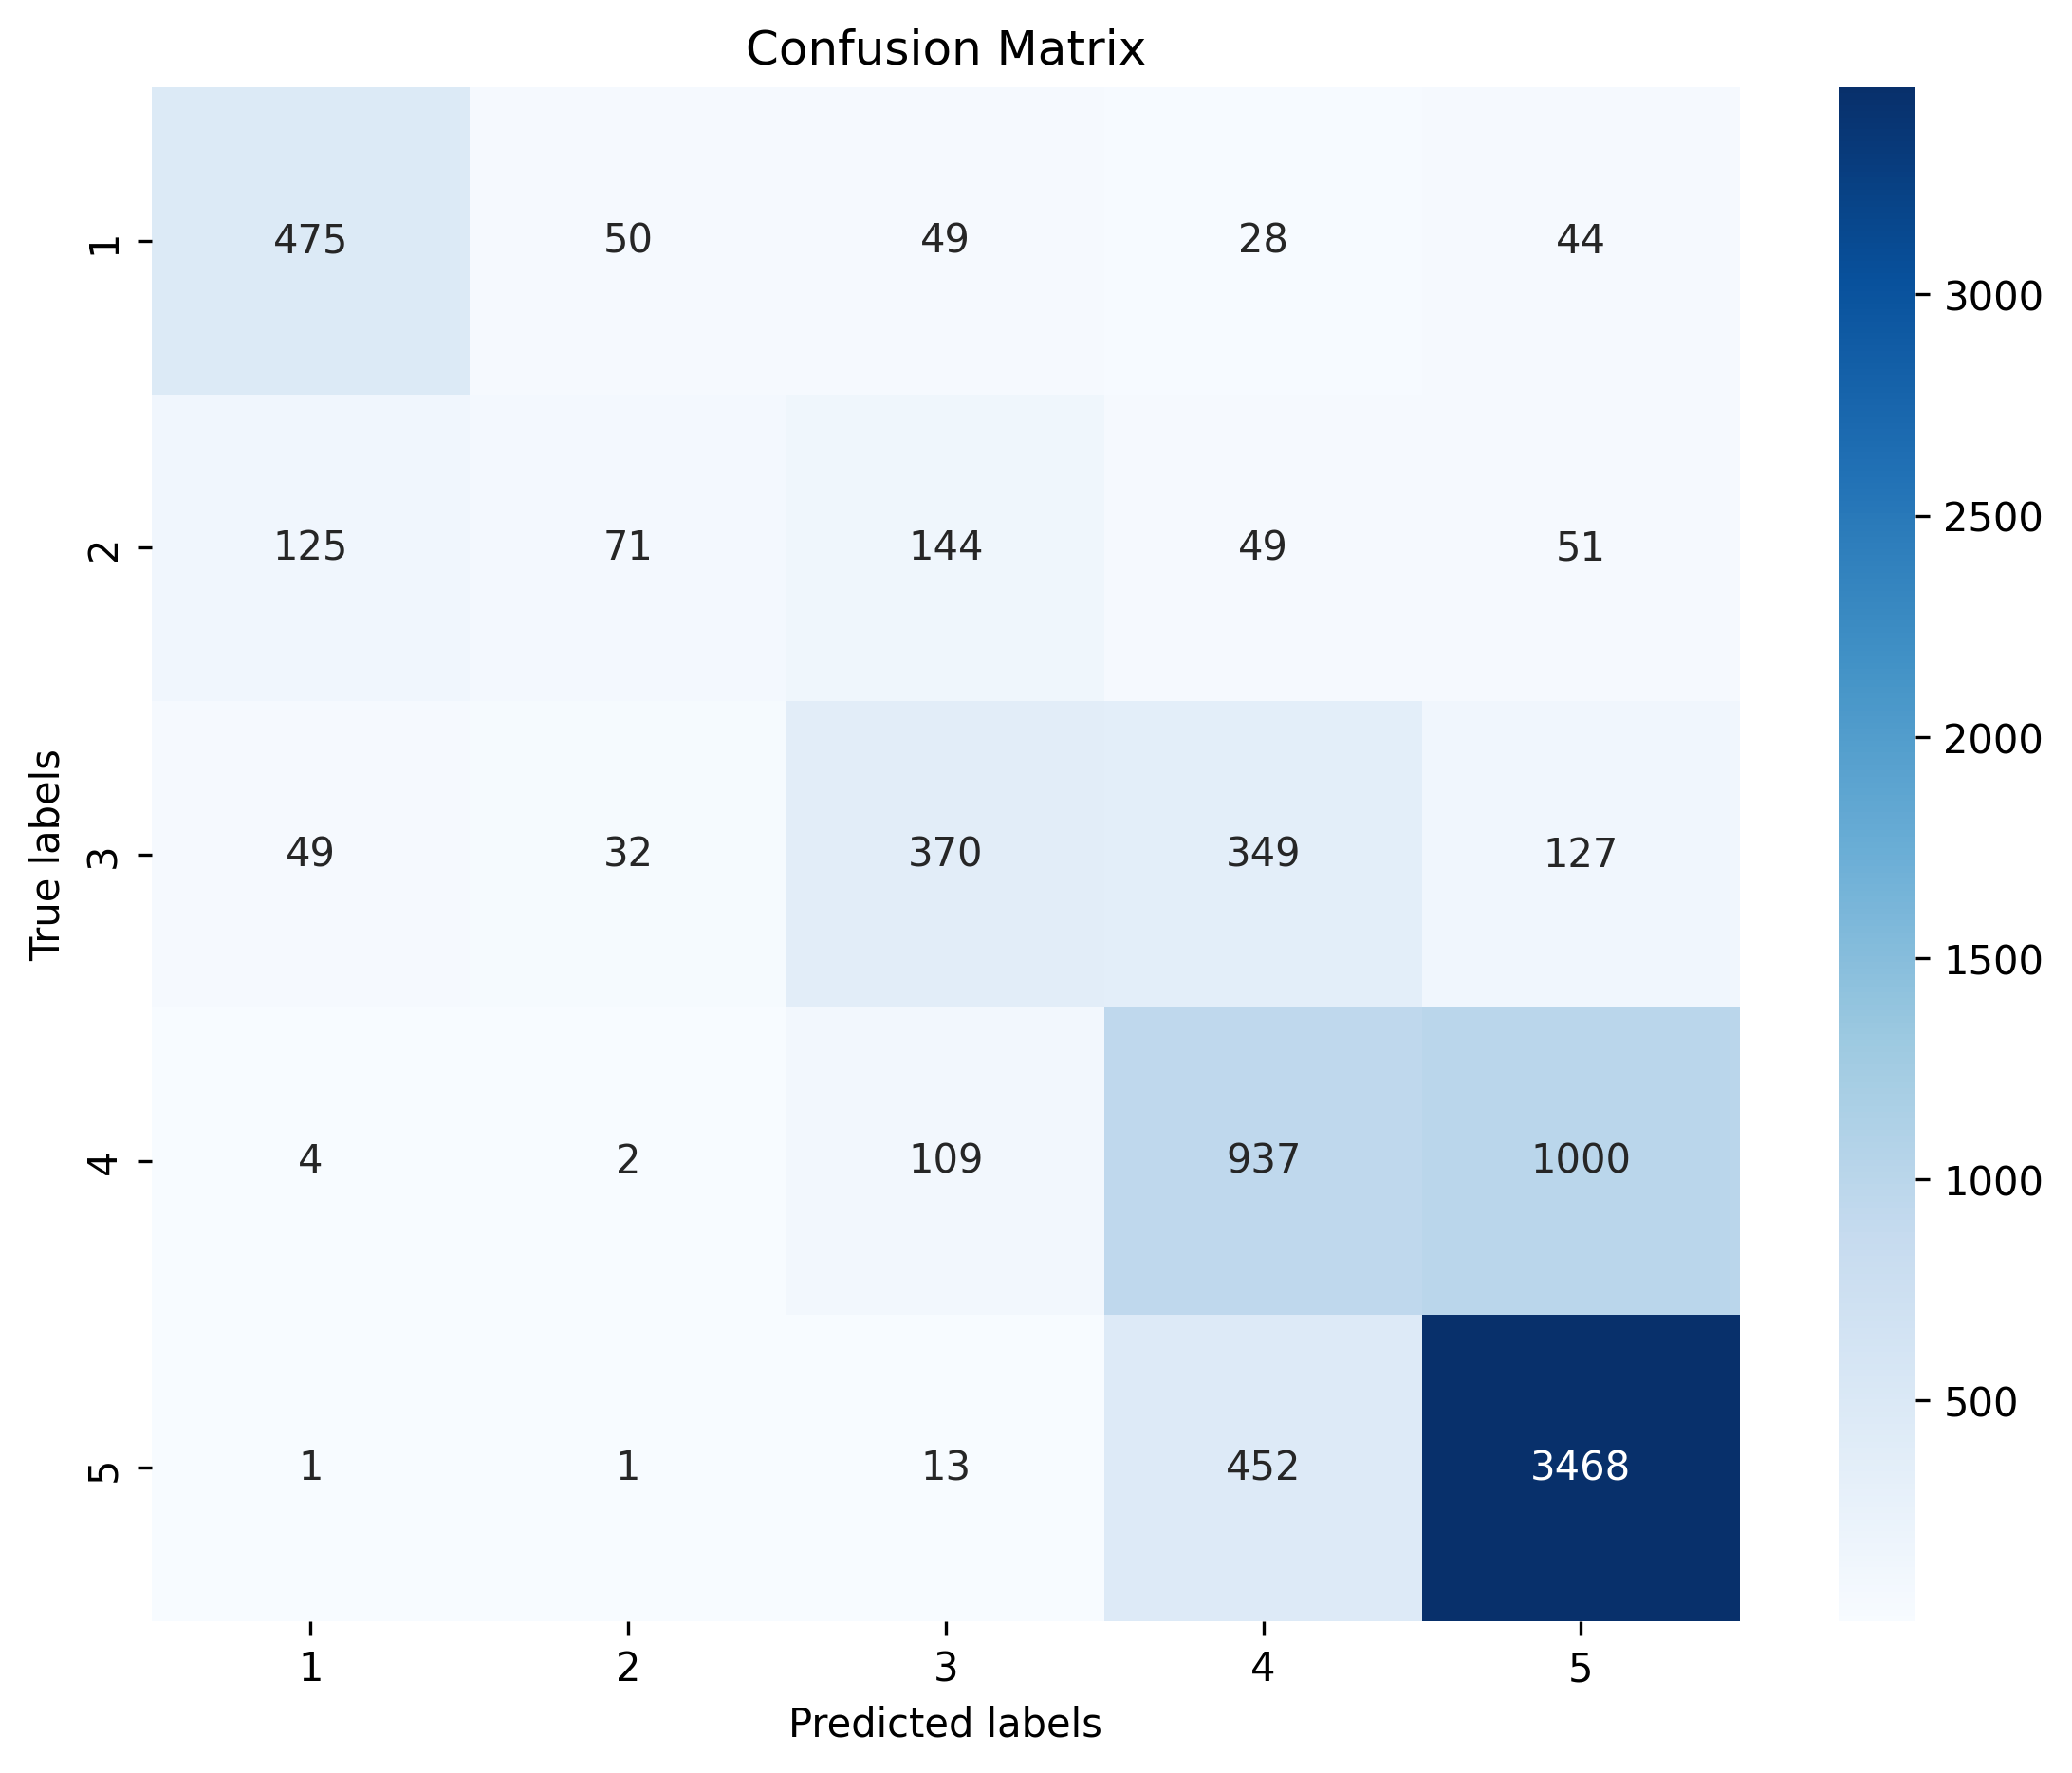

In [37]:
cm = confusion_matrix(y_test, predictions, labels=model.classes_)

# Plotting the confusion matrix with a heatmap
plt.figure(figsize=(9,7), dpi=300)
sb.heatmap(cm, annot=True, fmt='d',
           cmap='Blues',
           xticklabels=model.classes_,
           yticklabels=model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Find similar documents with tfidf
So far, we used the tfidf-vectors as feature vectors to train machine learning models. As we just saw, this works very well to predict review rating or to classify documents as positive/negative (=sentiment analysis).

But there is more we can do with tfidf vectors.
Why not use the vectors to compute distances or similarities? This way, we can search for the most similar documents in a corpus!

In [38]:
vectorizer = TfidfVectorizer(min_df=10, max_df=0.2,
                             max_features=25000,
                             ngram_range=(1, 3))  
tfidf_vectors = vectorizer.fit_transform(X_train)
tfidf_vectors.shape

(32000, 25000)

In [39]:
tfidf_vectors.shape

(32000, 25000)

In [40]:
X_train.shape

(32000,)

#### Compare one vector to all other vectors
Even though we here deal with very large vectors, computing similarities or angles between these vectors is compuationally very efficient. This means, we can simply compare a the tfidf vector of a given text to all > 140,000 documents in virtually no time!

In order for this to work, however, we should not rely on for-loops. Those are inherently slow in Python. We rather use optimized functions for this such as from `sklear.metrics.pairwise`.

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

review_id = -11#-9#-2
query_vector = tfidf_vectors[review_id, :]

cosine_similarities = cosine_similarity(query_vector, tfidf_vectors).flatten()
cosine_similarities.shape

(32000,)

In [42]:
np.sort(cosine_similarities)[::-1]

array([1.        , 0.17378527, 0.14885286, ..., 0.        , 0.        ,
       0.        ])

In [43]:
np.argsort(cosine_similarities)[::-1]

array([31989, 20283, 29369, ..., 11293, 23850,     0], dtype=int64)

In [44]:
top5_idx = np.argsort(cosine_similarities)[::-1][1:6]
top5_idx

array([20283, 29369, 29235, 11133,  4271], dtype=int64)

Let us now look at the results of our search by displaying the top-5 most similar documents (according to the cosine score on the tfidf-vectors). This usually doesn't work perfectly, but it does work to quite some extent. Try it out yourself and have a look at what documents this finds for you!

In [45]:
print("\n****Original document:****")
print(X_train.iloc[review_id])

for i in top5_idx:
    print(f"\n----Document with similarity {cosine_similarities[i]:.3f}:----")
    print(X_train.iloc[i])


****Original document:****
Can get buckets of beers for between 4 -5 Euros (5 beers in a bucket). Offer cheap sandwitches, rations of things such as calamari (which I had and was great). They have a terrace and a large screen TV for the football if that floats your boat.

----Document with similarity 0.174:----
Great place to call in before or after the football at Rel Madrid.Good selection of beers and reasonable prices.

----Document with similarity 0.149:----
This place located next to Moncloa station is a cheap option to get beers for a cheap price and tapas. They have tvs broadcasting football games as well.

----Document with similarity 0.147:----
excellent "ensaladilla rusa" and the "ventresca salad" was delicious too. Big cold Heineken pints and a large selection of beers. Will be back when I come back to Madrid

----Document with similarity 0.139:----
Great local bar for breakfast and delicious snacks. Good variety of beers with friendly attentive staff. It’s always busy with

## Word Vectors: Word2Vec and Co
**Tfidf vectors** are a rather basic, but still often used, technique. Arguably, this is because they are based on relatively simple statistics and easy to compute. They typically do a good job in weighing words according to their importance in a larger corpus and allow us to ignore words with low *distriminative power* (for instance so-called *stopwords* such as "a", "the", "that", ...).

With **n-grams** we can even go one step further and also count sentence pieces longer than one word. With n-grams our models can identify important word combinations such as negations ("do not like"), comparatives, or specific expressions ("the best") into account. The price, however, is that we have to restrict the number of n-grams to avoid exploding vector sizes.

TF-IDF vectors and n-grams serve as powerful techniques to represent and manipulate text data, but they have limitations. These methods treat words, or tiny groups of words, as individual, isolated units, devoid of any context or relation to other words. In other words, they cannot capture the semantic meanings of words and the linguistic context in which they are used.

Take these two sentences as an example:

(1) *The customer likes cake with a cappuccino.*  
(2) *The client loves to have a cookie and a coffee.*

We will immediately identify that both sentences speak of very similar things. But if you look at the words in both sentences you will realize that only *"The"* and *"a"* are found in both. And, as we have seen in the tfidf-part, such words tell very little about the sentence content. All other words, however, only occur in one or the other sentence. Tfidf-vectors would compute a zero similarity here.

This is where we come to **word vectors**. Word vectors, also known as **word embeddings**, are mathematical representations of words in a high-dimensional space where the semantic similarity between words corresponds to the geometric distance in the embedding space. Simply put, similar words are close together, and dissimilar words are farther apart. If done well, this should show that *"cookie"* and *"cake"* are not the same word, but mean something very related.

The most prominent example of such a technique is **Word2Vec** {cite}`mikolov_distributed_2013`{cite}`mikolov_efficient_2013`.

### Word2Vec

The fundamental idea behind Word2Vec is to use the context in which words appear to learn their meanings. As shown in the {numref}`fig_word2vec_sliding_window`, a sliding window of a fixed size (in this case, 5) moves across the sentence "The customer likes cake with a cappuccino." At each step, the algorithm selects a target word and its surrounding context words. The goal is to predict the target word based on its context or vice versa.

For example, in the phrase "the customer likes," the target word is "the," and the context words are "customer" and "likes." This process is repeated for each possible position in the sentence. These word-context pairs are fed into the Word2Vec model, which learns to map each word to a unique vector in such a way that words appearing in similar contexts have similar vectors. This vector representation captures semantic similarities, meaning that words with similar meanings or usages are positioned closer together in the vector space. Word2Vec thus enables various applications such as sentiment analysis, machine translation, and recommendation systems by providing a mathematical representation of words that reflects their meanings and relationships.

Word2Vec models can be trained using two main methods: Continuous Bag of Words (CBOW) and Skip-Gram. In CBOW, the model predicts a target word based on its surrounding context words, focusing on understanding the word's context to infer its meaning. Conversely, the Skip-Gram model predicts the surrounding context words given a target word, emphasizing the ability to generate context from a single word {cite}`mikolov_distributed_2013`{cite}`mikolov_efficient_2013`.

```{figure} ../images/fig_word2vec_sliding_window.png
:name: fig_word2vec_sliding_window

Techniques such as Word2Vec learn vector representations of individual words based on their "context", which is given by the neighboring words. 
```


In [46]:
import nltk

tokenizer = nltk.tokenize.TreebankWordTokenizer()
stemmer = nltk.stem.WordNetLemmatizer()

def process_document(doc):
    """Convert document to lemmas."""
    tokens = tokenizer.tokenize(doc)
    tokens = [x.strip(".,;:!? ") for x in tokens]
    return [stemmer.lemmatize(w) for w in tokens]

The entire text will be divided into sentences, that will be our "documents" in Word2vec terms. To reduce the computation time we will only use a fraction of the sentences, but feel free to repeat the following code parts with all sentences.

In [47]:
from tqdm.notebook import tqdm

sentences = [process_document(doc) for doc in tqdm(X_train.values[:50_000])]

  0%|          | 0/32000 [00:00<?, ?it/s]

In [48]:
len(sentences)

32000

We will now train our own Word2Vec model using `Gensim`, see also [documentation](https://radimrehurek.com/gensim/models/word2vec.html#usage-examples).

In [49]:
from gensim.models import Word2Vec

# Assume 'sentences' is a list of lists of tokenized sentences
model = Word2Vec(sentences,
                 vector_size=200,
                 window=5,
                 min_count=2,
                 workers=4)

In particular when we work with very large text corpora, training models such as Word2Vec can be time consuming. Usually, we therefore want to save the trained models for later re-use.

In [50]:
model.save("word2vec_madrid_reviews.model")

In [51]:
vector = model.wv['delicious']  # get numpy vector of a word

In [52]:
# just to get an idea how these vectors look like
vector[:20]

array([-1.4631869 , -0.05559831,  0.39984354,  0.15573464, -0.14774899,
        0.25873232,  1.5644163 , -1.6560258 , -1.3033752 ,  1.0558473 ,
       -0.27145493,  0.85104716, -0.20251557, -0.08595984,  0.7888863 ,
        1.6268817 ,  0.6412106 , -0.9122024 ,  0.08710601,  1.4958798 ],
      dtype=float32)

Let's now have a look at what work similarities we can get from the Word2Vec model that we just trained on the above sentences.

In [53]:
model.wv.most_similar('delicious', topn=10)

[('yummy', 0.8396993279457092),
 ('tasty', 0.8190354108810425),
 ('fantastic', 0.797711968421936),
 ('amazing', 0.7694064974784851),
 ('superb', 0.7590488195419312),
 ('incredible', 0.7415671944618225),
 ('awesome', 0.731024980545044),
 ('fabulous', 0.7295147776603699),
 ('excellent', 0.7162023186683655),
 ('outstanding', 0.7123649716377258)]

In [54]:
model.wv.most_similar('pizza', topn=10)

[('burger', 0.8356331586837769),
 ('hamburger', 0.7318969368934631),
 ('sushi', 0.7282989025115967),
 ('paella', 0.709283709526062),
 ('pasta', 0.6990393400192261),
 ('topping', 0.6848579049110413),
 ('ramen', 0.6826577186584473),
 ('salad', 0.6797074675559998),
 ('Paella', 0.6767290234565735),
 ('nacho', 0.6652087569236755)]

In [55]:
model.wv.most_similar('horrible', topn=10)

[('terrible', 0.9122419953346252),
 ('awful', 0.9071341156959534),
 ('okay', 0.8175601363182068),
 ('exceptional', 0.7787550091743469),
 ('OK', 0.7667417526245117),
 ('appalling', 0.7664023041725159),
 ('alright', 0.760648787021637),
 ('bad', 0.7457209825515747),
 ('poor', 0.7435242533683777),
 ('disgusting', 0.724142849445343)]

In [56]:
model.wv.most_similar('friendly', topn=10)

[('attentive', 0.8337773084640503),
 ('polite', 0.8126139640808105),
 ('welcoming', 0.8104057312011719),
 ('courteous', 0.786596953868866),
 ('helpful', 0.7858976125717163),
 ('professional', 0.7741507887840271),
 ('efficient', 0.7360875010490417),
 ('accommodating', 0.7276390790939331),
 ('unfriendly', 0.7047622203826904),
 ('personable', 0.6888341903686523)]

In [57]:
model.wv.most_similar('chocolate', topn=10)

[('cake', 0.905112087726593),
 ('strawberry', 0.8713018894195557),
 ('lemon', 0.8591129779815674),
 ('sorbet', 0.8582943081855774),
 ('cream', 0.8480873703956604),
 ('yogurt', 0.8371832966804504),
 ('mango', 0.8347520232200623),
 ('churros', 0.8343153595924377),
 ('flan', 0.8268107175827026),
 ('mousse', 0.8255254626274109)]

In [58]:
model.wv.most_similar('coffee', topn=10)

[('snack', 0.7619227170944214),
 ('tea', 0.7462546825408936),
 ('beer', 0.739642322063446),
 ('croissant', 0.702121376991272),
 ('juice', 0.6998605132102966),
 ('churros', 0.6767247319221497),
 ('pastry', 0.663308322429657),
 ('soda', 0.6511281132698059),
 ('chocolate', 0.6489554047584534),
 ('desert', 0.6475496888160706)]

## Alternative short-cuts
Training your own Word2Vec model is fun and sometimes also really helpful. Here it is quite OK for instance, because we have a relatively big text corpus (> 140,000 documents) with a clear general topic focus on restaurants and food.

Often, however, you simply may want to use a model that covers a language more broadly. Instead of training your own model on a much bigger corpus, we can simply use a model that was trained already, see for instance here [on the Gensim website](https://radimrehurek.com/gensim/models/word2vec.html#usage-examples).

Another way is to use **SpaCy**. Its larger language models already contain word embeddings!

In [59]:
# Comment out and run the following to first download a large english model
#!python -m spacy download en_core_web_lg

In [60]:
import spacy

nlp = spacy.load("en_core_web_lg")

As we have seen before, SpaCy converts the text into tokens, but also does much more. We can look at different attributes of the tokens to extract the computed information. For instance:

- `.text`: The original token text.
- `has_vector`: Does the token have a vector representation?
- `.vector_norm`: The L2 norm of the token’s vector (the square root of the sum of the values squared)
- `.is_oov`: Out-of-vocabulary


In [61]:
tokens = nlp("dog cat banana afskfsd")
for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

dog True 75.254234 False
cat True 63.188496 False
banana True 31.620354 False
afskfsd False 0.0 True


In [62]:
tokens[0].vector

array([ 1.2330e+00,  4.2963e+00, -7.9738e+00, -1.0121e+01,  1.8207e+00,
        1.4098e+00, -4.5180e+00, -5.2261e+00, -2.9157e-01,  9.5234e-01,
        6.9880e+00,  5.0637e+00, -5.5726e-03,  3.3395e+00,  6.4596e+00,
       -6.3742e+00,  3.9045e-02, -3.9855e+00,  1.2085e+00, -1.3186e+00,
       -4.8886e+00,  3.7066e+00, -2.8281e+00, -3.5447e+00,  7.6888e-01,
        1.5016e+00, -4.3632e+00,  8.6480e+00, -5.9286e+00, -1.3055e+00,
        8.3870e-01,  9.0137e-01, -1.7843e+00, -1.0148e+00,  2.7300e+00,
       -6.9039e+00,  8.0413e-01,  7.4880e+00,  6.1078e+00, -4.2130e+00,
       -1.5384e-01, -5.4995e+00,  1.0896e+01,  3.9278e+00, -1.3601e-01,
        7.7732e-02,  3.2218e+00, -5.8777e+00,  6.1359e-01, -2.4287e+00,
        6.2820e+00,  1.3461e+01,  4.3236e+00,  2.4266e+00, -2.6512e+00,
        1.1577e+00,  5.0848e+00, -1.7058e+00,  3.3824e+00,  3.2850e+00,
        1.0969e+00, -8.3711e+00, -1.5554e+00,  2.0296e+00, -2.6796e+00,
       -6.9195e+00, -2.3386e+00, -1.9916e+00, -3.0450e+00,  2.48

In [65]:
nlp1 = nlp(X_train.iloc[0])
nlp2 = nlp(X_train.iloc[1])

In [66]:
nlp1.similarity(nlp1)

1.0

In [67]:
nlp1.similarity(nlp2)

0.871706511976592

In [68]:
nlp1

I you want to discover how the humans lived in Ice Ages come to this restaurant. Expensive, bad quality, good service. Choose another near, there are hundreds.

In [69]:
nlp2

But be warned, it is very much a tourist trap and overpriced. Look around the nearby streets and you'll find a much more authentic experience with much more reasonable prices for tapas, sweets and drinks. It is what it is though- so some people will enjoy the loveliness and convenience and it is a lovely space.

### Limitations and More Powerful Alternatives

While Word2Vec is a powerful tool, it has limitations. One significant issue is that Word2Vec assigns one vector per word, which poses a problem for words with multiple meanings based on their context (homonyms and polysemes, such as "apple" the fruit vs. "apple" the company).

A more fundamental limitation of Word2Vec and similar algorithms lies in the underlying bag-of-words approach, which removes information related to the order of words. Even constructs like n-grams can only compensate for extremely local patterns, such as differentiating "do not like" from "do like".

In contrast, deep learning techniques like recurrent neural networks and, more powerfully, **transformers**, can learn patterns across many more words. Transformers, in particular, can learn patterns across entire pages of text {cite}`vaswani2017attention`, enabling models like ChatGPT and other large language models to use natural language with unprecedented subtlety. Models such as BERT (Bidirectional Encoder Representations from Transformers) {cite}`devlin2018bert` and GPT (Generative Pretrained Transformer) {cite}`radford2019language` produce contextualized representations of words within a given context, taking the entire sentence or paragraph into account rather than generating static word embeddings. Working in Python also allows you to try and test many different transformer models, for instance via *huggingface* {cite}`wolf2019huggingface`.

In conclusion, while TF-IDF and n-grams offer a solid start, word embeddings like those produced by Word2Vec and contextualized representations from transformers provide more advanced methods for working with text by considering context and semantic meaning.

## More on NLP
It should come as no surprise that there is *much* more to learn about NLP than what was presented in this, and the previous chapters.

Very good starting points for going deeper are:
- The book "Speech and Language Processing" by Jurafsky and Martin {cite}`jurafsky2024speech`, see [link to the book](https://web.stanford.edu/~jurafsky/slp3/).
- "Natural language processing with transformers" by Tunstall, von Werra, and Wolf {cite}`tunstall2022natural`